# Restaurants at New York City newly build houses.

## Contents
- Introduction
- Data cleaning
- Data exploration
- Hypothesis testing
- Visualization

The dataset contains data about permits for construction and demolition activities in the City of New York. These permatis are issued for maintenance, plumbing, demolition and other types of work. I will use the information about buildings' age to decide if there is a link between the age and a quality of a restaurant. For this project I will use another [dataset](https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/43nn-pn8j), which provides information about healt inspections at New York restaurants.

The datasets are large enough to be stored in a database, so I copied it to PostreSQL.
The permit dataset has 60 columns, but I will use only addresses, permit types and permit dates. 
I will start from cleaning the data. While addresses and streets can be difficult to validate, I can easily do this with dates, zip codes and borough.

In [2]:
from sqlalchemy import create_engine
import zipcodes
from pandas import DataFrame
from folium import plugins
import folium
from folium.plugins import HeatMap

In [4]:
engine = create_engine('postgresql://sofiagodovykh:@localhost/DS')
connection = engine.connect()
borough = connection.execute('SELECT DISTINCT(borough) FROM nyc;')
for item in borough:
    print(item)

/Users/sofiagodovykh/venv3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


('BRONX',)
('MANHATTAN',)
('QUEENS',)
('BROOKLYN',)
('STATEN ISLAND',)


Bogough column is fine. Then I will check zipcodes, using zipcodes library.

In [57]:
addresses = set()
problems = []
sql_zips = connection.execute('SELECT DISTINCT(zipcode) FROM nyc;')
for zip in sql_zips:
    try:
        temp = zipcodes.matching(str(zip[0]))
        addresses.add(temp[0]['city'] + ' ' + temp[0]['state'])
    except:
        problems.append(zip[0])
    
print(addresses)
print(problems)

{'RIDGEWOOD NY', 'CORONA NY', 'BRONX NY', 'BAYSIDE NY', 'MASPETH NY', 'LITTLE NECK NY', 'CAMBRIA HEIGHTS NY', 'FOREST HILLS NY', 'ASTORIA NY', 'ELMHURST NY', 'COLLEGE POINT NY', 'SUNNYSIDE NY', 'SPRINGFIELD GARDENS NY', 'JAMAICA NY', 'ROSEDALE NY', 'RICHMOND HILL NY', 'EAST ELMHURST NY', 'BLOOMING GROVE NY', 'FLUSHING NY', 'HOWARD BEACH NY', 'GLEN OAKS NY', 'OZONE PARK NY', 'HOLLIS NY', 'REGO PARK NY', 'KEW GARDENS NY', 'NEW HYDE PARK NY', 'SOUTH RICHMOND HILL NY', 'SOUTH OZONE PARK NY', 'WOODSIDE NY', 'BROOKLYN NY', 'MIDDLE VILLAGE NY', 'CHESTER NY', 'QUEENS VILLAGE NY', 'OAKLAND GARDENS NY', 'FAR ROCKAWAY NY', 'JACKSON HEIGHTS NY', 'WHITESTONE NY', 'SAINT ALBANS NY', 'BREEZY POINT NY', 'ARVERNE NY', 'FLORAL PARK NY', 'WOODHAVEN NY', 'LONG ISLAND CITY NY', 'ROCKAWAY PARK NY', 'FRESH MEADOWS NY', 'BELLEROSE NY', 'NEW YORK NY', 'STATEN ISLAND NY'}
[None, 10000, 4452, 10487, 0, 11376]


Most of the zipcodes are in New York metropolitan area. Let's see how many of them a erroneous.

In [73]:
connection.execute('SELECT COUNT(zipcode) FROM nyc WHERE zipcode IN (NULL, 10000, 4452, 10487, 0, 11376);').scalar()

246

There is only 246 wrong zipcodes. I will delete them.

In [74]:
connection.execute('DELETE FROM nyc WHERE zipcode IN (NULL, 10000, 4452, 10487, 0, 11376);')

Then I will take care of dates. I am mostly interested in expirationdate, since it is an indicator that building is finally finished. I have ran a query to find the earliest and the latest dates of permits for building new houses.

In [126]:
print(connection.execute('SELECT DISTINCT(expirationdate) FROM nyc WHERE expirationdate = '
                   '(SELECT MAX(expirationdate) from nyc WHERE permittype = \'NB\');').scalar())
print(connection.execute('SELECT DISTINCT(expirationdate) FROM nyc WHERE expirationdate = '
                   '(SELECT MIN(expirationdate) from nyc WHERE permittype = \'NB\');').scalar())

2020-04-01


1990-02-01


This data looks valid. But there is a tricky part: permits can be reissued, so it is possible that building has multiple permits. For my purpose, I need to use only the final one. I will create a column with the final date for each building.

In [220]:
print(connection.execute('SELECT COUNT(DISTINCT(CONCAT(borough, zipcode, house, streetname))) '
                   'FROM nyc WHERE permittype = \'NB\';').scalar())

86141


So, the dataset stores an information about 86141 houses which were built since 1990. I am very satisfied with this dataset. The next step is to validate another one.

For the health inspection dataset I will need to check data for borough, zipcode and inspection date (Inspection dates of 1/1/1900 mean an establishment has not yet had an inspection, therefore this data need to be removed).

In [131]:
borough = connection.execute('SELECT DISTINCT(boro) FROM restaurants;')
for item in borough:
    print(item)

('STATEN ISLAND',)
('MANHATTAN',)
('BRONX',)
('Missing',)
('BROOKLYN',)
('QUEENS',)


Borough column is fine: some of the information is missed, but it is not critical, I have zipcodes.

In [132]:
addresses = set()
problems = []
sql_zips = connection.execute('SELECT DISTINCT(zipcode) FROM restaurants;')
for zip in sql_zips:
    try:
        temp = zipcodes.matching(str(zip[0]))
        addresses.add(temp[0]['city'] + ' ' + temp[0]['state'])
    except:
        problems.append(zip[0])
    
print(addresses)
print(problems)

{'RIDGEWOOD NY', 'CORONA NY', 'BRONX NY', 'BAYSIDE NY', 'MASPETH NY', 'LITTLE NECK NY', 'CAMBRIA HEIGHTS NY', 'FOREST HILLS NY', 'ASTORIA NY', 'ELMHURST NY', 'COLLEGE POINT NY', 'SUNNYSIDE NY', 'SPRINGFIELD GARDENS NY', 'JAMAICA NY', 'ROSEDALE NY', 'RICHMOND HILL NY', 'EAST ELMHURST NY', 'FLUSHING NY', 'HOWARD BEACH NY', 'GLEN OAKS NY', 'OZONE PARK NY', 'HOLLIS NY', 'KEW GARDENS NY', 'SOUTH RICHMOND HILL NY', 'NEW HYDE PARK NY', 'REGO PARK NY', 'WOODSIDE NY', 'SOUTH OZONE PARK NY', 'BROOKLYN NY', 'MIDDLE VILLAGE NY', 'QUEENS VILLAGE NY', 'OAKLAND GARDENS NY', 'SCHENECTADY NY', 'FAR ROCKAWAY NY', 'JACKSON HEIGHTS NY', 'SAINT ALBANS NY', 'WHITESTONE NY', 'BREEZY POINT NY', 'ARVERNE NY', 'FLORAL PARK NY', 'WOODHAVEN NY', 'LONG ISLAND CITY NY', 'ROCKAWAY PARK NY', 'FRESH MEADOWS NY', 'BELLEROSE NY', 'NEW YORK NY', 'STATEN ISLAND NY'}
[None, 'N/A', '10000']


I removed the wrong data.

In [137]:
connection.execute('DELETE FROM restaurants WHERE zipcode IN (\'10000\', \'N/A\', NULL);')

According to dataset documentation, I need to delete some data from inspection_date column (Inspection dates of 1/1/1900 mean an establishment has not yet had an inspection).

In [143]:
print(connection.execute('SELECT COUNT(*) FROM restaurants '
                         'WHERE inspectiondate = \'01/01/1900\';').scalar())
connection.execute('DELETE FROM restaurants WHERE inspectiondate = \'01/01/1900\';')

Both datasets are cleaned, it is time to explore the data.
I will gather some basic statistics and build plots for the most interesting data.

How new buildings are distributed among New York boroughs?

In [205]:
res = connection.execute('SELECT borough, COUNT(distinct(CONCAT(borough, zipcode, house, streetname))) '
                         'FROM nyc WHERE permittype = \'NB\' '
                         'GROUP BY borough '
                         'ORDER BY COUNT(distinct(CONCAT(borough, zipcode, house, streetname))) DESC;')

df = DataFrame(res.fetchall())
df.columns = res.keys()

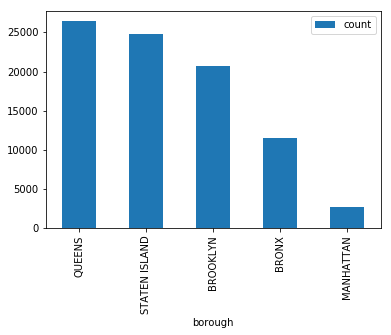

In [206]:
df.plot(kind = 'bar', x = 'borough')

In [210]:
res = connection.execute('SELECT SUBSTRING(expirationdate, 1, 4), '
                         'COUNT(distinct(CONCAT(borough, zipcode, house, streetname))) FROM nyc '
                         'WHERE permittype = \'NB\''
                         'GROUP BY SUBSTRING(expirationdate, 1, 4) ORDER BY SUBSTRING(expirationdate, 1, 4);')
df = DataFrame(res.fetchall())
df.columns = res.keys()

   substring  count
0       1990    169
1       1991    919
2       1992   1804
3       1993   2401
4       1994   3218
5       1995   3304
6       1996   3484
7       1997   4407
8       1998   4878
9       1999   5578
10      2000   6510
11      2001   7686
12      2002   9561
13      2003   9903
14      2004  11659
15      2005  12743
16      2006  14092
17      2007  12956
18      2008  10901
19      2009   8240
20      2010   5770
21      2011   4881
22      2012   4288
23      2013   4174
24      2014   4652
25      2015   4976
26      2016   5689
27      2017   5980
28      2018   5823
29      2019   5099
30      2020    813
31      None    295


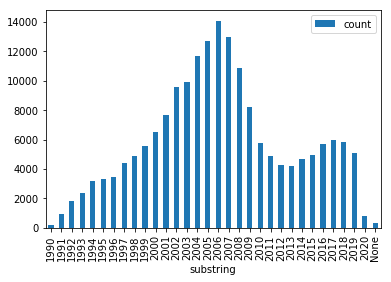

In [211]:
print(df)
df.plot(kind = 'bar', x = 'substring')

I want to see how it looks on a map.

In [67]:
points = connection.execute('SELECT DISTINCT(CONCAT(borough, zipcode, house, streetname)), '
                            'latitude, longitude FROM nyc WHERE permittype = \'NB\' AND '
                            'latitude <> \'NULL\' AND longitude <> \'NULL\';')

In [68]:
df = DataFrame(points.fetchall())
df.columns = points.keys()

In [69]:
df.head(10)

,concat,latitude,longitude
0,BRONX10451120EAST 149 STREET,40.819014,-73.929082
1,BRONX10451150E 151 ST,40.821231,-73.927581
2,BRONX10451151EAST 151 STREET,40.821239,-73.927563
3,BRONX10451164CANAL STREET WEST,40.811696999999995,-73.929769
4,BRONX10451180EAST 156TH STREET,40.823263,-73.923889
5,BRONX10451198EAST 135TH STREET,40.810776000000004,-73.93141
6,BRONX104511EAST 161 STREET,40.829035,-73.928497
7,BRONX10451200E 161 STREET,40.826337,-73.920963
8,BRONX10451200EAST 135 STREET,40.810699,-73.931313
9,BRONX10451201EAST 144 STREET,40.816092,-73.926484


In [71]:
subset = subset[['latitude', 'longitude']]
print(subset.size)
heat_data = []
for i in range(0, subset.size):
    heat_data.append([float(subset.loc[i, 'latitude']), float(subset.loc[i, 'longitude'])])
    

heatmap = folium.Map(location=[40.730610, -73.935242],
                    zoom_start = 13)
HeatMap(heat_data).add_to(heatmap)
heatmap

20000


KeyError: 10000